# From the tied array to likelihood

Tied array code is nicely developed by Brad. Now let's use it for a test case to develope the likelihood.

## Prerequisites

In [1]:
# For basic algebra and stats
import numpy as np
import scipy.stats as st

# For inference
import pymc as pm

# For visualization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
import cmasher as cms
import arviz as az

# Setting latex fonts in Matplotlib
rc('text', usetex=True)
rc('font', family='serif')

# Version check and print
from print_versions import print_versions
print_versions(globals())

numpy==1.26.2
pymc==5.12.0
matplotlib==3.8.0
cmasher==1.7.2
arviz==0.16.0


## Data - tied array beams

This is the data behind $T(\hat{q})$ which is defined in eq. 6 in the paper.

Command behind the data used here:

```bash
mwa_tab_loc -m ../data/1253471952.metafits -f 155000000 -t "2019-11-19T17:59:50" -L "04:52:41.10_-34:21:11.10 04:51:47.06_-34:21:11.10 04:52:14.13_-34:11:21.12 04:52:14.02_-34:31:01.07 04:51:20.20_-34:11:21.12 04:51:19.99_-34:31:01.07" --gridbox "04:46:00 -33:30:00 04:58:00 -35:10:00 5 5" --nopb --plot
```

Data are just numpy arrays, saved in `npy` and `npz` formats for quick load.

**Note**: We are only dealing with single-frequency data for the moment.


In [2]:
def data_reader(tabp_file, grid_file):
    tabp_look = np.load(tabp_file)
    print("Selecing the first frequency and ignoring all other frequencies")
    tabp_look = tabp_look[:,0,:,:]
    grid_ra = np.load(grid_file)['arr_0']
    grid_dec = np.load(grid_file)['arr_1']
    #product = np.sum(tabp_look.mean(axis=1), axis=0)
    print('tabp dimensions:', tabp_look.shape)
    #print('product dimensions:', product.shape)
    print('RA/Dec grid dimensions:', grid_ra.shape, grid_dec.shape)
    
    return tabp_look, grid_ra, grid_dec


TABP_LOOK, GRID_RA, GRID_DEC = data_reader('./tabp_look.npy', './grid.npz')

Selecing the first frequency and ignoring all other frequencies
tabp dimensions: (6, 408, 588)
RA/Dec grid dimensions: (408, 588) (408, 588)


## EDA

Visualizing the beams:

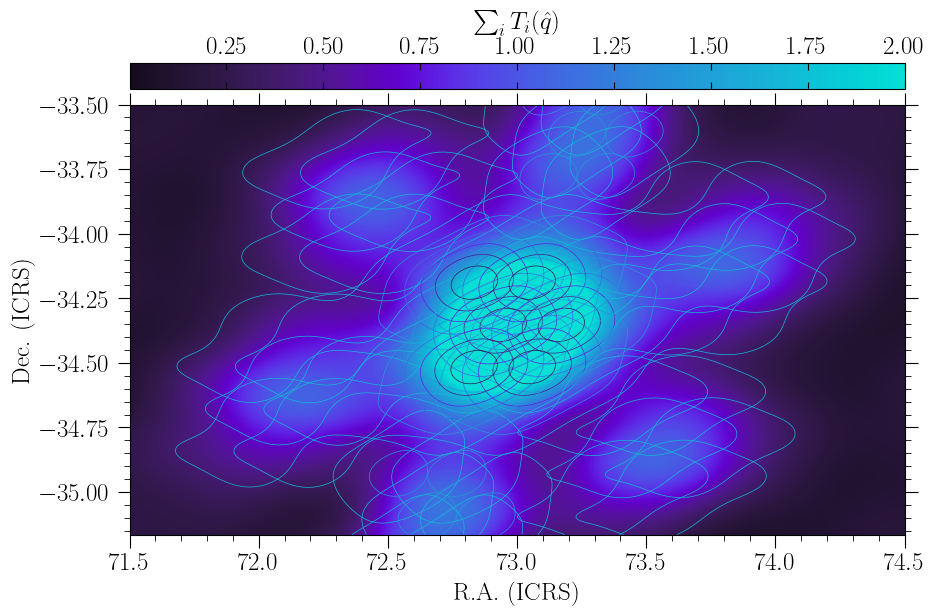

In [3]:
def eda_plot(tabp, grid_ra, grid_dec,label, contours=True):
    tabp_sum = np.sum(tabp, axis=0)

    map_extent = [grid_ra.min(),
                  grid_ra.max(),
                  grid_dec.min(),
                  grid_dec.max()]
    
    aspect = 'equal'    

    cmap = cms.get_sub_cmap(cms.cosmic,0.1,0.9)
    contour_cmap = cms.get_sub_cmap(cms.cosmic_r,0.1,0.9)
    cmapnorm_sum = colors.Normalize(vmin=1e-3, vmax=2, clip=True)
    cmapnorm_indiv = colors.Normalize(vmin=1e-3, vmax=1, clip=True)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1_img = ax1.imshow(tabp_sum,
                         aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm_sum)

    if contours:
        for look in tabp:
            ax1.contour(look, origin='image', extent=map_extent, cmap=contour_cmap, norm=cmapnorm_indiv, linewidths=0.5)

    ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
    ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='major', length=9)
    ax1.tick_params(axis='both', which='minor', length=4.5)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)

    cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=1, orientation='horizontal',location='top', aspect=30, pad=0.02)
    cbar.ax.set_title(label,fontsize=18,ha='center')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(direction='in',length=5,bottom=True,top=True)
    cbar.ax.xaxis.set_tick_params(labelsize=18)
    return fig

eda_plot(TABP_LOOK, GRID_RA, GRID_DEC, r'$\sum_i T_i(\hat{q})$');

The background colormap represents the sum over all look directions. The contour lines are vague representation of individual look directions.

## Model - part I: defining a point source

A putative point spread function:
$$ S(\hat{q}|\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}, F) = \frac{F}{2 \pi} \operatorname{det}(\boldsymbol{\Sigma}_\textrm{src})^{-1 / 2} \exp \left(-\frac{1}{2}(\hat{q}-\hat{\mu}_\textrm{src})^{\mathrm{T}} \boldsymbol{\Sigma}_\textrm{src}^{-1}(\hat{q}-\hat{\mu}_\textrm{src})\right) $$

Where $F$ is an equivalent of flux and when $F=1$, the function is a PDF. For the moment we assume $F=1$, but probably will set it as a random variable in inference.

We start with the simple case of circular point source with a standard deviation of 15 arcmin:
$$ \boldsymbol{\Sigma}_\textrm{src} = \begin{bmatrix}
       15' & 0 \\[0.3em]
       0   & 15'
     \end{bmatrix}
$$

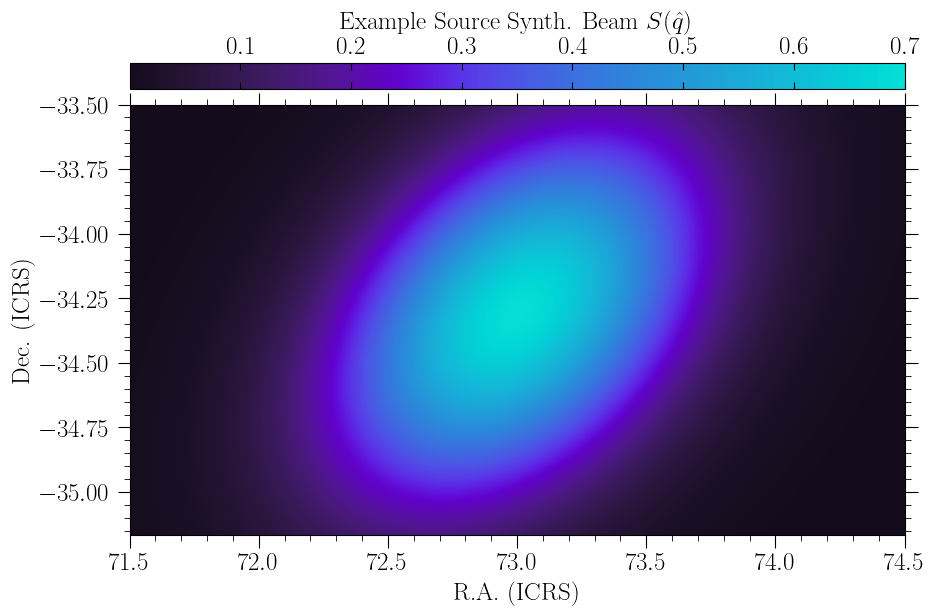

In [24]:
def pointsource(ra, dec, src_ra, src_dec, cov, F):
    """
    Assumes ra and dec are 2D arrays as grids (same shape!)
    src_ra and src_dec in degrees
    cov can either be a single value (i.e., diag. cov) or a 2x2 matrix
    """
    
    # Theoretical PDF
    pointsource_model = st.multivariate_normal(np.array([src_ra, src_dec]), cov=cov)
    
    # Flattening and joining the coordinates grids into a 2*m array:
    coords_flat = np.array([np.ravel(ra),np.ravel(dec)]).T
    pointsource_on_grid_flatarrays = F * pointsource_model.pdf(coords_flat)

    # Now folding the PDF grid back to the grid shape:
    # RA and Dec should be the same shape
    grid_x_size = ra.shape[0]
    grid_y_size = ra.shape[1]
    pointsource_on_grid_folded = np.reshape(pointsource_on_grid_flatarrays, (grid_x_size, grid_y_size))
    return pointsource_on_grid_folded


def pointsrc_plot(grid_ra, grid_dec, src_ra, src_dec, src_cov, src_F):
    example_target_synthbeam_fold = pointsource(grid_ra, grid_dec, src_ra, src_dec, src_cov, src_F)

    map_extent = [grid_ra.min(),
                  grid_ra.max(),
                  grid_dec.min(),
                  grid_dec.max()]
    
    aspect = 'equal'    

    cmap = cms.get_sub_cmap(cms.cosmic,0.1,0.9)
    cmapnorm = colors.Normalize(vmin=1e-8, vmax=0.7, clip=False)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1_img = ax1.imshow(example_target_synthbeam_fold,
                         aspect=aspect, extent=map_extent, cmap=cmap, norm=cmapnorm)
    #ax1.set_title('Example Source Synth. Beam', fontsize=18, pad=20)
    ax1.set_xlabel('R.A. (ICRS)',fontsize=18,ha='center')
    ax1.set_ylabel('Dec. (ICRS)',fontsize=18,ha='center')
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='major', length=9)
    ax1.tick_params(axis='both', which='minor', length=4.5)
    ax1.tick_params(axis='both', which='both', direction='out', right=True, top=True)
    
    cbar = fig.colorbar(ax1_img, ax=fig.axes, shrink=1, orientation='horizontal',location='top', aspect=30, pad=0.02)
    cbar.ax.set_title(r'Example Source Synth. Beam $S(\hat{q})$',fontsize=18,ha='center')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.tick_params(direction='in',length=5,bottom=True,top=True)
    cbar.ax.xaxis.set_tick_params(labelsize=18)

    return fig

# Symmetric
#pointsrc_plot(GRID_RA, GRID_DEC, 73.0029167, -34.3116667, 15/60);
# Asymmetric
pointsrc_plot(GRID_RA, GRID_DEC, 73.0029167, -34.3116667, [[15/60,0.1],[0.1,15/60]], 1);

## Model - part II: likelihood-free inference setup

### Background and Inputs
Re-iterating the definition of point spread function:
$$ S(\hat{q}|\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}, F_\textrm{src}) = \frac{F_\textrm{src}}{2 \pi} \operatorname{det}(\boldsymbol{\Sigma}_\textrm{src})^{-1 / 2} \exp \left(-\frac{1}{2}(\hat{q}-\hat{\mu}_\textrm{src})^{\mathrm{T}} \boldsymbol{\Sigma}_\textrm{src}^{-1}(\hat{q}-\hat{\mu}_\textrm{src})\right) $$

Where $F_\textrm{src}$ is an equivalent of flux and when $F_\textrm{src}=1$, the function is a PDF.

We start with the simple case of circular point source with a standard deviation of 15 arcmin:
$$ \boldsymbol{\Sigma}_\textrm{src} = \begin{bmatrix}
       15' & 0 \\[0.3em]
       0   & 15'
     \end{bmatrix}
$$

What we really "observe" are the SNR values from each of the looks - $T(\hat{q})$ in the paper, so for $N$ number of looks, what we observe is:

$$ \boldsymbol{\mathcal{w}} = [\mathcal{w}_1,\cdots,\mathcal{w}_i,\cdots,\mathcal{w}_N];\quad\quad 1\leq i\leq N $$

### Problem statement and motivation for ABC

In abstraction, we can start from what are trying to link:

$$\mathcal{w}_i = \textrm{SNR}(T_i,\hat{\mu}_\textrm{src}) \propto  T_i(\hat{q}), \hat{\mu}_\textrm{src}, \cdots $$

However, the exact calculation of ${w}_i$ is complex and considers time-series data which is not a dimension we are exploring. Additionally, there is little information regarding the probabilistic properties of a likelihood on $\mathcal{w}_i$. Thus we resort to approximate bayesian computation (ABC) methods (for an introduction see [Sisson et al. 2018](https://arxiv.org/abs/1802.09720) and [Martin et al. 2021](https://bayesiancomputationbook.com/welcome.html)). For this, we need a generative model simulating ${w}_i$. Starting from what we have:

- **Observed** quantities that represent the location of the celestial source are $\mathcal{w}_i$.
- **Model** parameters we wish to constrain: $\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}$.
- **Nuisance** parameters: $F_\textrm{src}$
- **Determined** parameters: Everything else.

We start with an ad-hoc simulation of $w_i$ which we will call $\bar{\mathcal{w}}_i$:

$$\displaystyle \mathcal{w}_i \sim \bar{\mathcal{w}}_i(\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}) = \int T_i(\hat{q}) S(\hat{q}|\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}) d\hat{q}$$

$\hat{q}$ is a vector on the celestial sphere as $\hat{q}=[\theta,\phi]$, and we have $T_i$ and $S$ - variable `TABP_LOOK` and function `pointsource` respectively - calculated for a rectangular grid in RA/Dec (ignoring the projection effects for the moment), so we can appropximate:

$$ \bar{\mathcal{w}}_i \approx \sum_{j,k} T_i(\hat{q}(\theta_j,\phi_k)) S(\hat{q}(\theta_j,\phi_k)|\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}) \delta\theta_j \delta\phi_k $$

So we can approximate our posterior:

$$ p(\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src}| \boldsymbol{\mathcal{w}}) \propto \delta(\boldsymbol{\mathcal{w}}, \bar{\boldsymbol{\mathcal{w}}}|\epsilon)p(\hat{\mu}_\textrm{src},\boldsymbol{\Sigma}_\textrm{src})$$

Where $\delta$ is our distance function and $\epsilon$ is tolerance.

### ABC setup

Now we need appropriate summary statistic, distance function and tolerance.

#### Distance
We can test a few distances, starting with weighted Euclidean distance:

$$ \delta(\boldsymbol{\mathcal{w}}, \bar{\boldsymbol{\mathcal{w}}}|\epsilon) = \sum_i - \frac{|\mathcal{w}_i- \bar{\mathcal{w}}_i|^2}{2\epsilon_i^2}$$

And we can test other choices like Laplace, Mahalanobis, Wasserstein distances or KL divergence. 

#### Tolerance
We can start with some value of $\epsilon$ that represents our knowledge of how $\mathcal{w}_i$ is measured and interrogate the posterior predictive to see if the choice is reasonable.

## Testing ground to build the computational model

array([13857.1939454 , 19524.44170543, 17797.94205222, 14649.73993927,
       23998.67792764, 20300.04535675])

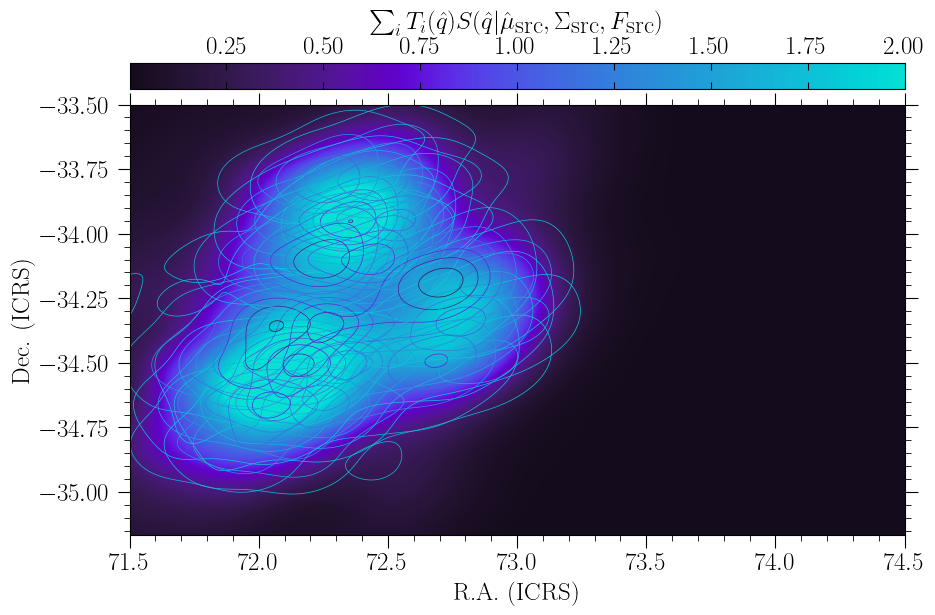

In [5]:
def sim_weights(src_ra, src_dec, cov, F, tabp, grid_ra, grid_dec, plotgrid = False):
    src_grid = pointsource(grid_ra, grid_dec, src_ra, src_dec, cov, F)
    sim_w_grid = src_grid * tabp
    sim_w = sim_w_grid.sum(axis=(1,2))

    if plotgrid:
        label = r'$\sum_i T_i(\hat{q}) S(\hat{q}|\hat{\mu}_\textrm{src},{\Sigma}_\textrm{src}, F_\textrm{src})$'
        fig = eda_plot(sim_w_grid, grid_ra, grid_dec, label, contours=True)
    
    return sim_w

sim_weights(72.0029167, -34.3116667, [[15/60,0.1],[0.1,15/60]], 5, TABP_LOOK, GRID_RA, GRID_DEC, plotgrid=True)

In [6]:
OBS_WEIGHTS = np.array([13,26,21,10,8,8])[:,None,None,None]

In [7]:
sim_weights(72.0029167, -34.3116667, [[15/60,0.1],[0.1,15/60]], 1e-3, TABP_LOOK, GRID_RA, GRID_DEC)

array([2.77143879, 3.90488834, 3.55958841, 2.92994799, 4.79973559,
       4.06000907])

In [25]:
with pm.Model() as model:
    src_ra = pm.Uniform('RA', lower=GRID_RA.min(), upper=GRID_RA.max())
    src_dec = pm.Uniform('Dec', lower=GRID_DEC.min(), upper=GRID_DEC.max())
    src_chol, src_corr, src_stds = pm.LKJCholeskyCov("Chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2))
    src_cov = pm.Deterministic("cov", src_chol.dot(src_chol.T))
    src_f = pm.Uniform('F',lower=0,upper=100)

pointsource(GRID_RA, GRID_DEC, src_ra, src_dec, src_cov, src_f)


ValueError: setting an array element with a sequence.

In [18]:
def simfunc(rng, src_ra, src_dec, cov, F, size=None):
    return sim_weights(72.0029167, -34.3116667, [[15/60,0.1],[0.1,15/60]], 1e-3, TABP_LOOK, GRID_RA, GRID_DEC)


def euclidian(observed_weights, grid_ra, grid_dec):
    with pm.Model() as model:
        weights_data = pm.ConstantData("Weights", observed_weights)
        
        src_ra = pm.Uniform('RA', lower=grid_ra.min(), upper=grid_ra.max())
        src_dec = pm.Uniform('Dec', lower=grid_dec.min(), upper=grid_dec.max())
        src_chol, src_corr, src_stds = pm.LKJCholeskyCov("Chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2))
        src_cov = pm.Deterministic("cov", src_chol.dot(src_chol.T))
        src_f = pm.Uniform('F',lower=0,upper=100)
        S = pm.Deterministic('SRCF',pointsource(grid_ra, grid_dec, src_ra, src_dec, src_cov, src_f))
        
        """
        sim = pm.Simulator("sim",simfunc, params = [src_ra, src_dec, src_cov, src_f], 
                           distance="gaussian",
                           sum_stat="sort",  
                           epsilon=1,
                           observed=weights_data)
        """
        return model


In [19]:
TEST = euclidian(OBS_WEIGHTS, GRID_RA, GRID_DEC)

with TEST:
    idata_test = pm.sample()

ValueError: setting an array element with a sequence.

/home/arash/anaconda3/envs/mwa_localization/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/arash/anaconda3/envs/mwa_localization/lib/python3.9/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/arash/anaconda3/envs/mwa_localization/lib/python3.9/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/arash/anaconda3/envs/mwa_localization/lib/python3.9/site-packages/arviz/stats/density_utils.py:699: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/home/arash/anaconda3/envs/mwa_localization/lib/python3.9/site-packages/arviz/stats/density_utils.py:699: RuntimeWa

OverflowError: cannot convert float infinity to integer

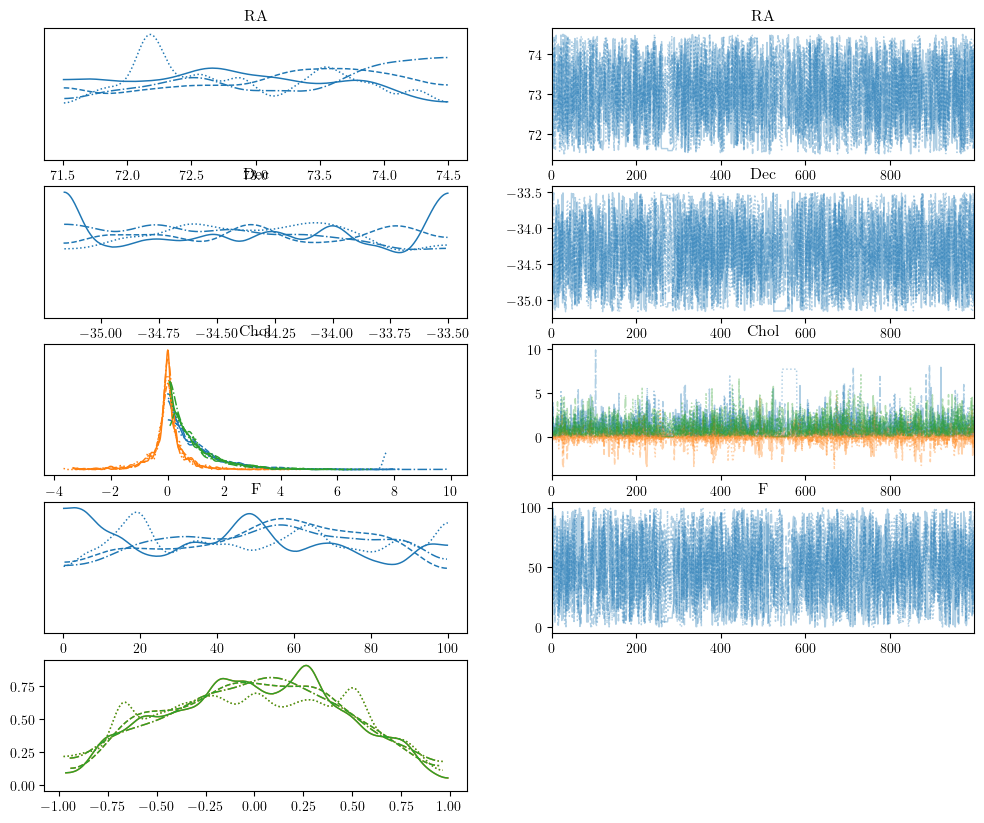

In [17]:
pm.MvNormal()